This is a notebook to demonstrate how to use the tools in demNet to request 3DEP point clouds from cloud hosted services provided by the USGS, turn those point clouds into grids, and produce derivatives

In [1]:
import sys
import os
sys.path.append('../demAnalysisComponents/') #Add the path to the demAnalysis scripts
sys.path.append('../demCreationComponents/')

import dem as dg
import pointCloudCreation as pCC

from matplotlib import pyplot as plt
import numpy as np

from importlib import reload

ModuleNotFoundError: No module named 'dem'

In [2]:
#First, example creating a DEM a heigt above ground model - this may take a while

testExtent = ([-105.602157,-105.548255],[37.606802,37.649582]) #Define an extent to request
testEPSG = 4326 #Define the SRS of the extent
outEPSG = 32613 #Define the output SRS
grid_name_dem = os.path.join('..','testData','test_slv') #Where do we want to save the data for the DEM?
grid_name_hag = os.path.join('..','testData','test_slv_hag') #Where do we want to save the data for the HAG?
usgs_survey_name = 'CO_San-Luis-Valley_2011' #What is the name of the dataset we are requesting from? Found at: https://usgs.entwine.io/
cell_size = 2.0 #Pixel size of resultant raster

#### Build DEM
#First get the JSON request description
pipeline = pCC.request_build_dem_creation_pipeline(testExtent,testEPSG,outEPSG,grid_name_dem,
                                                   usgs_survey_name,cell_size = cell_size)
pCC.run_pipeline(pipeline) #Then execute this request

### Build a height above ground raster (e.g., cannopy height)
#First get the JSON request description
pipeline = pCC.request_build_hag_creation_pipeline(testExtent,testEPSG,outEPSG,grid_name_hag,usgs_survey_name,
                                                   cell_size = cell_size)
pCC.run_pipeline(pipeline) #Execute the request



[Text(0, 4162000.0, ''),
 Text(0, 4163000.0, ''),
 Text(0, 4164000.0, ''),
 Text(0, 4165000.0, ''),
 Text(0, 4166000.0, ''),
 Text(0, 4167000.0, ''),
 Text(0, 4168000.0, '')]

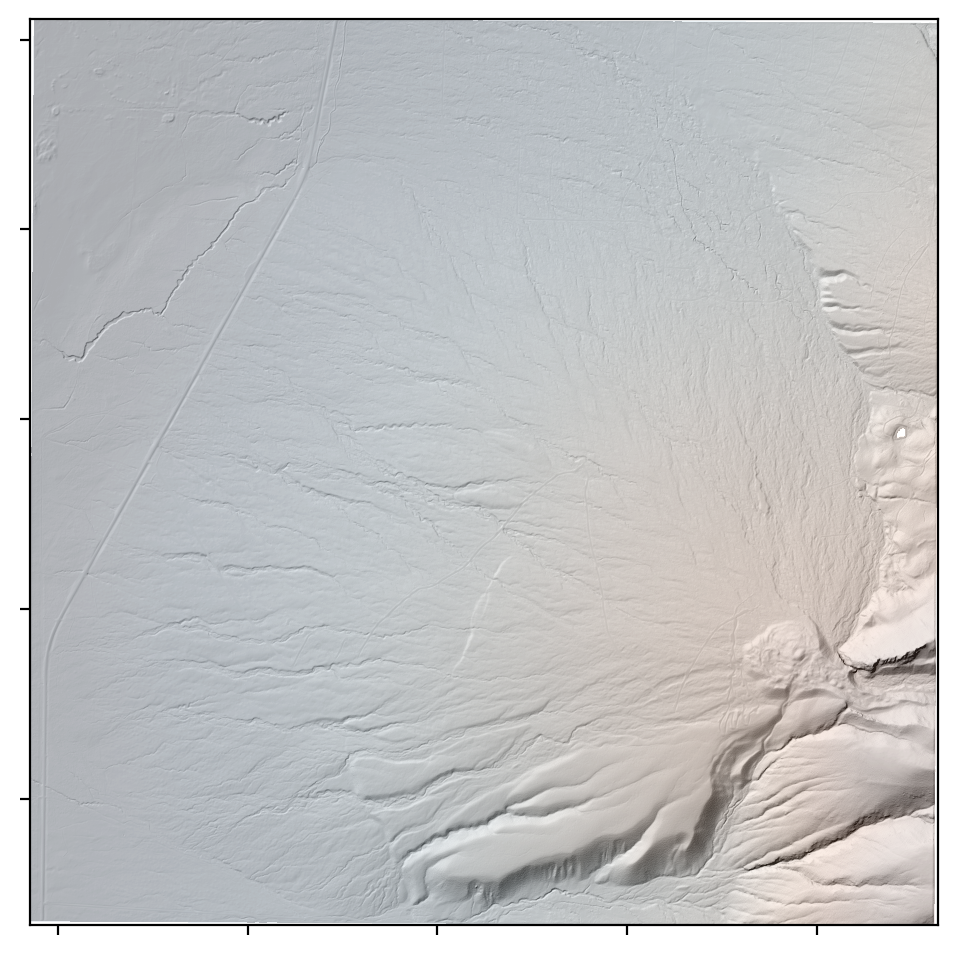

In [3]:
#Now lets visualize what 
dem= dg.demGrid([],rasterPath=grid_name_dem+'.tif')
dem[dem <0] = np.nan
hs = dem.calcHillshade()
hag = dg.demGrid([],rasterPath = grid_name_hag+'.tif')

f,axs = plt.subplots(1,1,figsize = (6,6),dpi = 200,sharex=True,sharey=True)

#Plot the hillshade
hs.plotGrid(axs = axs,cmap = 'gray',vmin = 0, vmax = 255)

#Plot the DEM as two different very transparent colormaps, just to play with overlay effects
dem.plotGrid(axs = axs,cmap = 'Blues_r',alpha = 0.1, vmin = 2340, vmax = 2750)
dem.plotGrid(axs = axs,cmap = 'Oranges',alpha = 0.1, vmin = 2500, vmax = 2950)

#Remove axis labels for clean axes
axs.set_xticklabels([])
axs.set_yticklabels([])


**Requesting point cloud profiles**

It's also possible to request swath profiles of point clouds from lines, for example the fault scarp present in the middle of the alluvial fan above.

[Text(0, 4162000.0, ''),
 Text(0, 4163000.0, ''),
 Text(0, 4164000.0, ''),
 Text(0, 4165000.0, ''),
 Text(0, 4166000.0, ''),
 Text(0, 4167000.0, ''),
 Text(0, 4168000.0, '')]

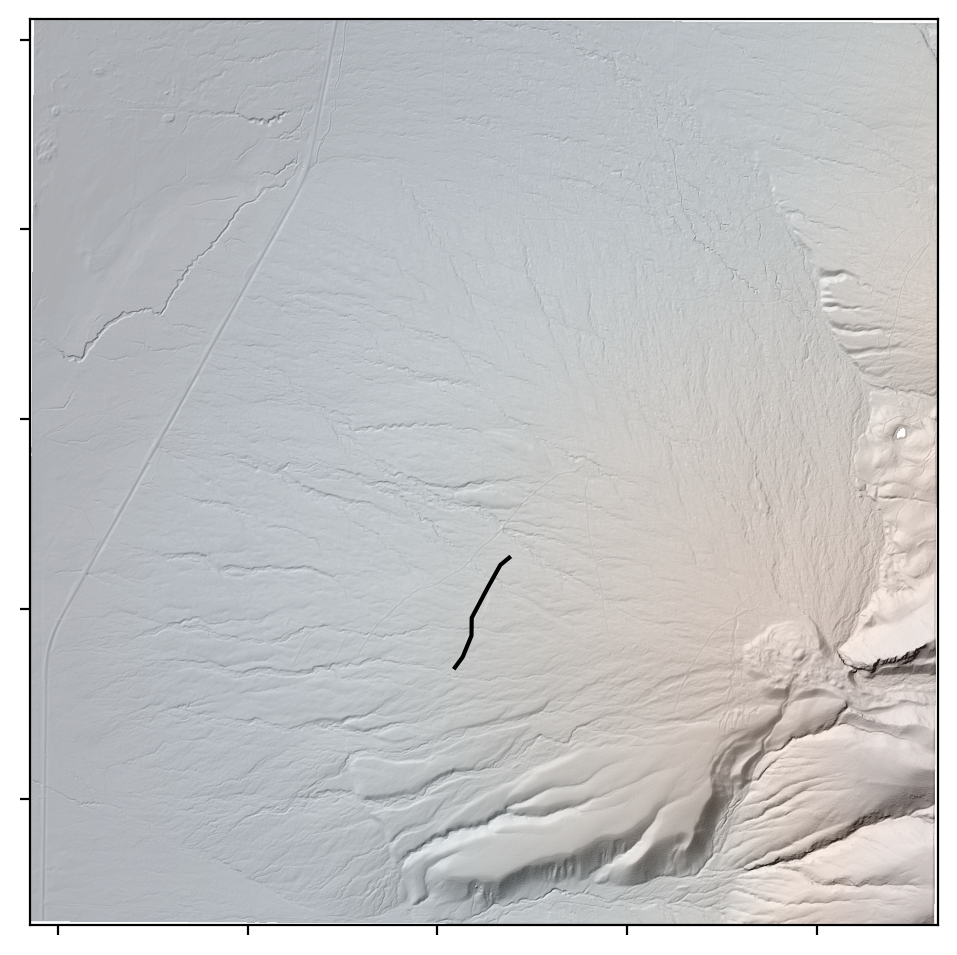

In [4]:


#First lets load in a trace of the fault scarp above
import geopandas as gpd

pathToFaultTrace = os.path.join('..','testData','vectorData','SLV_Zapata_FaultScarp.shp')

fsGDF = gpd.read_file(pathToFaultTrace)
f,axs = plt.subplots(1,1,figsize = (6,6),dpi = 200,sharex=True,sharey=True)

#Plot the hillshade
hs.plotGrid(axs = axs,cmap = 'gray',vmin = 0, vmax = 255)

#Plot the DEM as two different very transparent colormaps, just to play with overlay effects
dem.plotGrid(axs = axs,cmap = 'Blues_r',alpha = 0.1, vmin = 2340, vmax = 2750)
dem.plotGrid(axs = axs,cmap = 'Oranges',alpha = 0.1, vmin = 2500, vmax = 2950)

#Plot the fault scarp
fsGDF.plot(ax = axs,color = 'k')

#Remove axis labels for clean axes
axs.set_xticklabels([])
axs.set_yticklabels([])




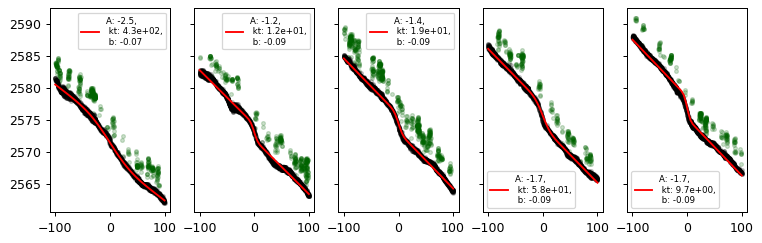

In [5]:


#Here we will request a series of orthogonal profiles to the line above
from scipy.special import erf
from scipy import optimize
from importlib import reload
reload(pCC)

nSwaths = 5 #Number of orthogonal profiles we will construct
swathPositions = np.linspace(0,1,nSwaths) #Relative positions along the line of the swaths

faultLine = fsGDF.geometry[0] #Get the line geometry

swathLength = 200.0
swathWidth = 3.0

f,axs = plt.subplots(1,nSwaths,figsize = (10,3),dpi = 90,sharex = True,sharey = True)




#Create some functions for fitting fault scarp morphology
def fsFun(L,params):
    #Solution for a scarp on an inclined surface smoothed by linear diffusion
    a,kt,b,c = params
    return a*erf((L)/(2.0*np.sqrt(kt))) + b*(L) + c

def fitFS(L,Z):
    #Optimizing for the best fitting paramaters in the above scarp profile solution
    objFun = lambda params : np.sum((Z - fsFun(L,params))**2)
    paramGuess = [1.0,10,0.0,np.mean(Z)]
    
    res = optimize.minimize(objFun,paramGuess).x
    return res


for i,relative_position in enumerate(swathPositions):
    
    
    #Execute the pipeline
    pipe = pCC.get_orthogonal_swathprofile_request_pointcloud(faultLine,
                                                             relative_position, swathLength,
                                                             swathWidth,outEPSG,
                                                             usgs_survey_name,
                                                             'profileTest',doSavePointCloud=False,
                                                            doReclassify = True)
    #Get the relevant data from the pipeline
    arrays = pipe.arrays[0]
    L = np.array(arrays['L']) - swathLength/2.0
    Z = np.array(arrays['Z'])
    C = np.array(arrays['Classification'])
    D = np.array(arrays['D'])
    X = np.array(arrays['X'])
    Y = np.array(arrays['Y'])
    
    #Which points are ground:
    isGrnd = C == 2
    
    #Fit the fault scarp
    bfParams = fitFS(L[isGrnd],Z[isGrnd])
    
    #Create a predicted FS line
    LtoFit = np.linspace(-swathLength/2.0,swathLength/2.0,50)
    Zfit = fsFun(LtoFit,bfParams)
    
    #Plot the result
    axs[i].plot(L[~isGrnd],Z[~isGrnd],'.',color = 'darkgreen',alpha =0.2)
    axs[i].plot(L[isGrnd],Z[isGrnd],'.',color = 'k',alpha =0.2)
    axs[i].plot(LtoFit,Zfit,'-r',label = 'A: {:.1f},\n kt: {:.1e},\n b: {:.2f}'.format(bfParams[0],bfParams[1],bfParams[2]))
    
    axs[i].legend(fontsize = 'x-small')
    


**Tiling large requests**

When making large requests it can be prohibitively slow to grab all the points of interest at once. Instead we will tile our request, selecting point clouds in a moving window, building DEMs from them, and then merging the DEMs.

In [6]:
#Now for a larger request we want to tile that request

extent = ([-108.59, -108.57],[36.601, 36.644]) #([MinX,MaxX],[MinY,MaxY])z
extentEPSG = 4326 #SRS for extent
outEPSG = 32613 #SRS for output
grid_name = os.path.join('..','testData','tileTest','HBack') #Save path
usgs_survey_name = 'CO_San-Luis-Valley_2011' #Name of source dataset
cell_size = 2.0 #What is the x,y pixel dimension for each grid?
tileWidth = 1e3 #How wide is each tile
tileOverlap = 10*cell_size #How much should each tile overlap

doKeepTiles = False #Do we want to keep the original tiles that were created?
doBuildDEMDerivatives = True #Do we want to build derivatives for DEMs?

#Paramaters for DEM derivatives
HS_AZ = 315 #Hillshade azimuth
HS_ELV = 45 #HS elevation angle
TPI_IN_MULT = 2 #Multiplier on cell size for inner annulus radius of TPI
TPI_OUT_MULT = 4 #Multiplier on cell size for outer annulus radius of TPI
SLOPE_WIN = 1 #Window size for slope magnitude kernel
CRV_WIN = 2 #Window size for second derivative kernel

### Define the routine we want to use in each tile to get point cloud tiles
pipeline_builder = lambda ext,ext_epsg,name: pCC.request_build_dem_creation_pipeline(ext,ext_epsg,pCC.ENTWINE_EPSG,name,
                                                                                  usgs_survey_name,cell_size)
#Get list of each tiled request pipeline to make
tiled_pipelines = pCC.get_tiled_request_pipelines(extent,extentEPSG,tileWidth,tileOverlap,grid_name,pipeline_builder)

#loop through and run the pipelines - using something like joblib / parallel this could be made embarassingly parallel
for i,pipeline in enumerate(tiled_pipelines):
    thisGrid = pipeline['pipeline'][-1]['filename']
    print('Working on tile {} of {}, name: {}'.format(i+1,len(tiled_pipelines),thisGrid))
    pCC.run_pipeline(pipeline)

### Once all the tiles are created, merge them
outExtent = pCC.reproject_extent(extent,extentEPSG,outEPSG)
dem_tile_names = [p['pipeline'][-1]['filename'] for p in tiled_pipelines]

print('Merging tiles into one DEM...')
pCC.merge_warp_dems(dem_tile_names,grid_name+'.tif',outExtent,outEPSG,cell_size,noDataValue = np.nan)


print('Tiles merged...')
#Delete the individual tiles if necessary
if not(doKeepTiles):
    print('Deleting tiles...')
    for i,fname in enumerate(dem_tile_names):
        os.remove(fname)

if doBuildDEMDerivatives:
    dem = dg.demGrid([], rasterPath=grid_name + '.tif')
    print('Loaded DEM, Building derivatives...')

    #Hillshade
    print('Building Hillshade...')
    HS = dem.calcHillshade(HS_AZ,HS_ELV)
    HS.overwriteSaveFile()

    #Slope magnitude
    print('Building Slope magnitude...')
    Smag = dem.calcFiniteSlopeMagOverWindow(SLOPE_WIN)
    Smag.overwriteSaveFile()


    #Curvature
    print('Building Curvature...')
    Crv = dem.calcFiniteLaplacianOverWindow(CRV_WIN)
    Crv.overwriteSaveFile()
    Crv_name = Crv._filePath


    #TPI
    print('Building Topographic position index...')
    TPI = dem.calcTPI(TPI_IN_MULT*cell_size,TPI_OUT_MULT*cell_size)
    TPI.overwriteSaveFile()

print('Completed')

Working on tile 1 of 10, name: ..\testData\tileTest\HBack_r0_c0.tif
Working on tile 2 of 10, name: ..\testData\tileTest\HBack_r0_c1.tif
Working on tile 3 of 10, name: ..\testData\tileTest\HBack_r1_c0.tif
Working on tile 4 of 10, name: ..\testData\tileTest\HBack_r1_c1.tif
Working on tile 5 of 10, name: ..\testData\tileTest\HBack_r2_c0.tif
Working on tile 6 of 10, name: ..\testData\tileTest\HBack_r2_c1.tif
Working on tile 7 of 10, name: ..\testData\tileTest\HBack_r3_c0.tif
Working on tile 8 of 10, name: ..\testData\tileTest\HBack_r3_c1.tif
Working on tile 9 of 10, name: ..\testData\tileTest\HBack_r4_c0.tif
Working on tile 10 of 10, name: ..\testData\tileTest\HBack_r4_c1.tif
Merging tiles into one DEM...
Tiles merged...
Deleting tiles...
Loaded DEM, Building derivatives...
Building Hillshade...
Building Slope magnitude...
Building Curvature...
Building Topographic position index...
Completed


<AxesSubplot:>

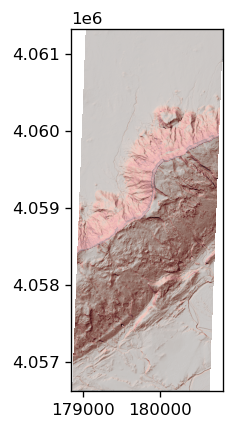

In [7]:
#Visualize the result - Slope magnitude
f,axs = plt.subplots(1,1,dpi = 120)

HS.plotGrid(axs = axs, cmap = 'gray',vmin = 0, vmax = 255)
Smag.plotGrid(axs = axs, cmap = 'Reds',vmin = 0, vmax = 1, alpha = 0.3)

<AxesSubplot:>

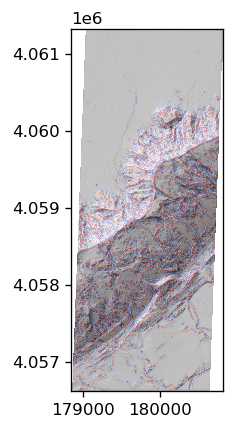

In [8]:
#Visualize the result - TPI 
f,axs = plt.subplots(1,1,dpi = 120)

HS.plotGrid(axs = axs, cmap = 'gray',vmin = 0, vmax = 255)
TPI.plotGrid(axs = axs, cmap = 'coolwarm',vmin = -0.25, vmax = 0.25, alpha = 0.3)